In [486]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as tt

from bokeh.plotting import figure, show
from bokeh.models import BoxAnnotation, Span, Label, Legend
from bokeh.io import output_notebook
from bokeh.palettes import brewer
output_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [487]:
#DM = as.data.frame(cbind(1,t,cos(pi*t*(1/6)), sin(pi*t*(1/6)), cos(pi*t*(2/6)), sin(pi*t*(2/6)), cos(pi*t*(3/6)), sin(pi*t*(3/6))))

In [488]:
def seasonal(t, s, c, period):
    sea = s[0] * np.sin((1*np.pi)*t/period) + s[1] * np.sin((2*np.pi)*t/period) + s[2] * np.sin((3*np.pi)*t/period) + c[0] * np.cos((1*np.pi)*t/period) + c[1] * np.cos((2*np.pi)*t/period) + c[2] * np.cos((3*np.pi)*t/period) 
    return sea

def drift(N,sig):
    steps = np.random.normal(loc=0, scale=sig, size=N) #std =5.304
    return np.cumsum(steps)

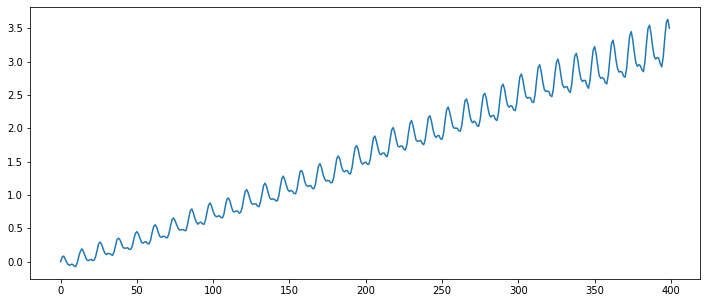

In [489]:
N = 400

t = np.array(range(N))
s = seasonal(t, [10,5,0.2], [5,-0.5,0.4], 6)
y = 2000 + t + s*np.exp(0.003*t) + drift(N,1) 

y_std = np.std(y)
y_first = y[0]

#y = 10 + 0.2*t + s + np.random.normal(0, 2, N)
y = (y - y_first)/y_std
plt.figure(figsize=(12,5))

plt.plot(t, y);

t = t.reshape(-1,1)

In [490]:
N_back = 50 
t_before = t[:-N_back]
y_before = y[:-N_back]

with pm.Model() as model:
    # yearly periodic component x long term trend
    #η_per = pm.HalfCauchy("η_per", beta=2, testval=1.0)
    #ℓ_pdecay = pm.Gamma("ℓ_pdecay", alpha=0.2, beta=0.075)
    period  = pm.Normal("period", mu=12, sigma=0.5)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=0.2, beta=0.15)
    
    ls_per = pm.HalfNormal("alpha_per", sigma=0.1)
    alpha_per = pm.HalfNormal("ls_per", sigma=0.2)
    tau_per = pm.HalfNormal("tau_per", sigma=2)
    cov_se = tau_per * pm.gp.cov.RatQuad(1, ls_per, alpha_per) 
    
    lin_c_per = pm.HalfNormal("lin_c_per", sigma=1)
    lin_tau_per = pm.HalfNormal("lin_tau_per", sigma=1)
    cov_linear_per = lin_tau_per * pm.gp.cov.Linear(1, lin_c_per)
    
    #cov_seasonal = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth) * pm.gp.cov.Matern52(1, ℓ_pdecay)
    cov_seasonal = pm.gp.cov.Periodic(1, period, ℓ_psmooth) * cov_se * cov_linear_per
    #cov_seasonal = pm.gp.cov.Periodic(1, period, ℓ_psmooth)
    
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)
    
    # small/medium term irregularities
    η_med = pm.HalfCauchy("η_med", beta=0.5, testval=0.1)
    ℓ_med = pm.Gamma("ℓ_med", alpha=2, beta=0.75)
    α = pm.Gamma("α", alpha=5, beta=2)
    cov_medium = η_med**2 * pm.gp.cov.RatQuad(1, ℓ_med, α)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # long term trend
    #η_trend = pm.HalfCauchy("η_trend", beta=2, testval=2.0)
    #ℓ_trend = pm.Gamma("ℓ_trend", alpha=4, beta=0.1)
    #cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(1, ℓ_trend)
    
    c = pm.HalfNormal("c", sigma=1)
    tau = pm.HalfNormal("tau", sigma=1)
    b = pm.HalfNormal("b", sigma=2)
    cov_linear = b + tau * pm.gp.cov.Linear(1, c)
    cov_trend = cov_linear
    
    gp_trend = pm.gp.Marginal(cov_func=cov_linear)

    σ  = pm.HalfNormal("σ",  sigma=0.25)
    cov_noise = cov_linear*pm.gp.cov.WhiteNoise(σ)

    # The Gaussian process is a sum of these three components
    gp = gp_medium + gp_trend + gp_seasonal
    #gp = gp_trend + gp_medium

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=t_before, y=y_before, noise=cov_noise)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [492]:
print("Sampling gp predictions ...")

mu_est, cov_est = gp.predict(t_before, point=mp)

tnew = np.array(range(N-N_back,N+100)).reshape(-1,1)
mu_pred, cov_pred = gp.predict(tnew, point=mp)

mu_est_sc = mu_est * y_std + y_first
sd_est_sc = np.sqrt(np.diag(cov_est) * y_std**2)
upper_est = mu_est_sc + 2*sd_est_sc
lower_est = mu_est_sc - 2*sd_est_sc

mu_pred_sc = mu_pred * y_std + y_first
sd_pred_sc = np.sqrt(np.diag(cov_pred) * y_std**2)

#sd_pred_sc = np.sqrt(np.diag(cov_pred) * std_co2**2 )

upper_pred = mu_pred_sc + 2*sd_pred_sc
lower_pred = mu_pred_sc - 2*sd_pred_sc

y_orig = y * y_std + y_first

t_before = t_before.flatten()
t_later = tnew.flatten()

Sampling gp predictions ...


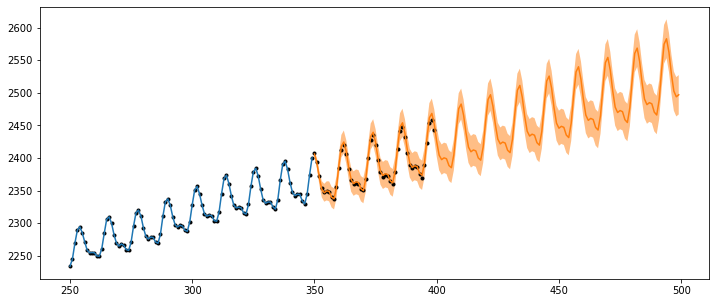

In [498]:
plt.figure(figsize=(12,5))

M = 100
plt.plot(t[-M-N_back:], y_orig[-M-N_back:], 'k.');
plt.plot(t_before[-M:], mu_est_sc[-M:])
plt.fill_between(t_before[-M:], lower_est[-M:], upper_est[-M:], alpha=0.5);
plt.plot(t_later, mu_pred_sc)
plt.fill_between(t_later, lower_pred, upper_pred, alpha=0.5);

